# Prisbildning på spot-marknaden
Först importerar vi lite funktioner.

In [1]:
from gridBalance import *
from ipywidgets import interact, IntSlider, FloatSlider

def plotBids(producers,consumers,x,f2z=[],xMin=0,xMax=None,yMax=None):
  nVar   = len(x)
  nZones = len(producers)
  nFlows = nVar - nZones
  
  #f2z    = zoneMap(nZones)
  if nFlows != len(f2z):
    print(x)
    print(nZones)
    print(nFlows)
    print(len(f2z))
    raise Exception('f2z needs to be provided if nZones > 1')
  
  if xMax==None:
    xMax = 2*np.max(x)
    
  netImport = np.zeros(nZones)
  netExport = np.zeros(nZones)
  for f in range(nFlows):
    i,j = f2z[f]
    flow = x[nZones + f]
    if flow > 0:
      netExport[i] += x[nZones + f]
      netImport[j] += x[nZones + f]
    else:
      netImport[i] -= x[nZones + f]
      netExport[j] -= x[nZones + f]
  p = np.linspace(xMin,xMax,2000)
  fig,ax=pl.subplots(nrows=nZones,figsize=(8,3.9+1.1*nZones),sharex=True,squeeze=False)
  for i in range(nZones):
    ax[i,0].plot(p,consumers[i](p),'-',color='#1f77b4',label='Buy')
    ax[i,0].plot(p,producers[i](p),'-',color='#ff7f0e',label='Sell')
    if nZones > 1:
      if netExport[i] > 1e-6:
        ax[i,0].plot(p,consumers[i](p)+netExport[i],'--',color='#1f77b4')
      if netImport[i] > 1e-6:
        ax[i,0].plot(p,producers[i](p)+netImport[i],'--',color='#ff7f0e')
    ax[i,0].plot(x[i],(producers[i])(x[i])+netImport[i],'or')
    ax[i,0].set_ylim(bottom=0,top=yMax)
    ax[i,0].set_ylabel('Load [MW]')
  ax[0,0].set_xlim((xMin,xMax))
  ax[0,0].legend(frameon=0,loc='upper left')
  ax[-1,0].set_xlabel('Price [€/MWh]')
  fig.tight_layout()
  
def plotBids2D(producers,consumers,x,f2z=[],xMin=0,xMax=None,yMax=None,ncols=2,labels=[]):
  nVar   = len(x)
  nZones = len(producers)
  nFlows = nVar - nZones
  
  if xMax==None:
    xMax = 2*np.max(x)
  
  if nFlows != len(f2z):
    raise Exception('f2z needs to be provided if nZones > 1')
  
  netImport = np.zeros(nZones)
  netExport = np.zeros(nZones)
  for f in range(len(f2z)):
    i,j = f2z[f]
    flow = x[nZones + f]
    if flow > 0:
      netExport[i] += x[nZones + f]
      netImport[j] += x[nZones + f]
    else:
      netImport[i] -= x[nZones + f]
      netExport[j] -= x[nZones + f]
  p = np.linspace(xMin,xMax,2000)
  nrows = int(np.ceil(nZones/ncols))
  fig,ax2D=pl.subplots(nrows=nrows,ncols=ncols,figsize=(4*ncols,2.7*nrows),sharex=False,squeeze=False)
  ax = ax2D.reshape(-1)
  for i in range(nZones):
    ax[i].plot(p,consumers[i](p),'-',color='#1f77b4',label='Buy')
    ax[i].plot(p,producers[i](p),'-',color='#ff7f0e',label='Sell')
    if nZones > 1:
      if netExport[i] > 1e-6:
        ax[i].plot(p,consumers[i](p)+netExport[i],'--',color='#1f77b4')
      if netImport[i] > 1e-6:
        ax[i].plot(p,producers[i](p)+netImport[i],'--',color='#ff7f0e')
    ax[i].plot(x[i],(producers[i])(x[i])+netImport[i],'or')
    ax[i].set_ylim(bottom=0,top=yMax)
    #ax[i].set_xlabel('Price [€/MWh]')
    ax[i].set_xlim((xMin,xMax))
    if len(labels)>0:
      ax[i].set_title(labels[i])
  for i in range(nrows):
    ax2D[i,0].set_ylabel('Load [MW]')
  for i in range(ncols):
    ax2D[-1,i].set_xlabel('Price [€/MWh]')
  ax[0].legend(frameon=0,loc='upper left')
  for i in range(nZones,nrows*ncols):
    ax[i].axis('off')
  fig.tight_layout()

### Introduktion
Den här övningen handlar om elhandel på spotmarknaden (t.ex. Nordpool), även kallad dagen-före-marknaden. Köpare och säljare lämnar bud till marknaden där de anger hur mycket el [MW] de vill köpa (efterfrågan) respektive sälja (utbud) vid olika priser [€/MWh]. Bud lämnas en dag i förväg och gäller för en specifik timme (kommer i framtiden ändras till en kvart). Ett marknadspris sätts för varje handelstimme så att köp- och säljbuden blir lika. Det är detta som kallas marginalprissättning. Att buden samlas in och matchas centralt på det här sättet kallas för indirekt auktion. Säljare utgörs av elhandelsbolag som producerar el och utgörs främst av kraftverk och vissa industrier. Köpare är främst elhandelsbolag som säljer till slutanvändare, eller större industrier. 

Principen för spotmarknaden är i huvudsak densamma som för vilken marknad som helst där utbud och efterfrågan ska balanseras. För elhandel är det dock extra viktigt med balans eftersom produktion och konsumption sker sammtidigt och i realtid. Varje avvikelse från balans måste kompenseras av systemoperatören genom upp- eller nedreglering av dyr reglerkraft. Det finns också en intradagsmarknad där man kan göra justeringar. Här ger vi en förenklad bild som enbart fokuserar på spotmarknaden. Hur reglerkraft och intradagsmarknad fungerar beskrivs i rapporterna.

Nedan följer ett hypotetiskt exempel på matchning mellan köp- och säljbud. Ju högre pris desto större säljbuden, och desto mindre köpbud. Linjerna korsar (förhoppningsvis) varandra någonstans, och där sätts marknadspriset.

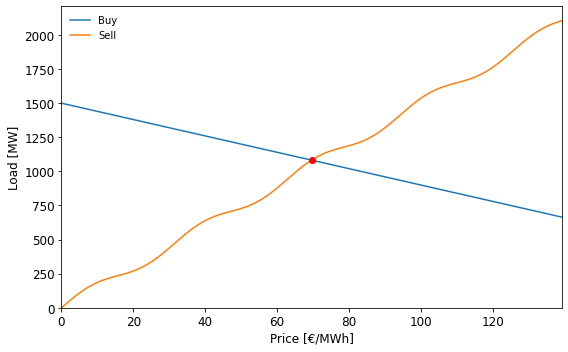

In [2]:
producer = [lambda p : (15.*p + 40*np.sin(p/5))]
consumer = [lambda p : np.maximum(0, 1500-6*p)]
x,f2z = solvePriceBalance(producer, consumer)

plotBids(producer,consumer,x)

### Meriteringsordning
I verkligheten är buden inte så jämna och fina som i exemplet ovan. Producenter som har kostnader för bränsle kan inte bjuda ut något under bränslepriset men bjuder ut hela sin kapacitet precis över bränslepriset. För vattenkraftsproducenter har vattnet i dammarna ett värde som beroende på hur full dammen är, vilken årstid det är och hur vädret förväntas utvecklas. Vind- och solkraftsproducenter har inga bränslekostnader och lägger ofta bud omkring noll; de accepterar vilket pris som helst. 

På köpsidan är buden inte särskilt priskänsliga, förbrukningen är ungefär densamma oavsett pris. En mer realistisk prismatchning skulle kunna se ut enligt figuren nedan. Efterfrågan är nästan prisoberoende och minskar bara marginellt med ökande pris. Produktionen består av: 
- 100 MW vindkraft som bjuds ut för 0 €/MWh
- 900 MW baskraft (t.ex kärnkraft och vattenkraft) bjuds ut i tre steg; 200, 300 och 400 MW bjuds ut vid 15, 25 respektive 30 €/MWh
- 400 MW stepskraft (t.ex gas eller oljekraft) bjuds ut i tre steg; vid 85, 100 och 110 €/MWh

Prova att ändra på efterfrågan och utbudet av vindkraft.
Vilket är det lägsta möjliga priset i exemplet?
Vad händer om efterfrågan är på max och vindproduktionen på 0?

In [3]:
def plotExample2(offset, windProd):
  producer = [lambda p : step(p,15,200) + step(p,25,300) + step(p,30,400) + step(p,85,150) + step(p,100,150) \
                       + step(p,110,100) + step(p,0,windProd)]
  consumer = [lambda p : np.maximum(0, offset-0.5*p)]
  x,f2z = solvePriceBalance(producer, consumer)
  plotBids(producer,consumer,x,xMin=-1,xMax=120,yMax=1800)

interact(plotExample2, offset=FloatSlider(min=600, max=1400, step=25, value=900, description='Efterfrågan'), \
                     windProd=FloatSlider(min=0, max=400, step=25, value=100, description='Vindproduktion') )

interactive(children=(FloatSlider(value=900.0, description='Efterfrågan', max=1400.0, min=600.0, step=25.0), F…

<function __main__.plotExample2(offset, windProd)>

### Efterfrågeflexibilitet
På en marknad där efterfrågan har stor priskänslighet minskar risken att auktionen inte går ihop. Idag är efterfrågeflexibiliteten på elmarknaden liten men den skulle kunna öka i framtiden om det tillkommer nya flexibla köpare t.ex energilager eller producenter av syntetiska bränslen. 

In [4]:
def plotExample3(offset, slope):
  producer = [lambda p : step(p,15,200) + step(p,25,300) + step(p,30,400) + step(p,85,150) + step(p,100,150) \
                       + step(p,110,100) + step(p,0,100)]
  consumer = [lambda p : np.maximum(0, offset-slope*p)]
  x,f2z = solvePriceBalance(producer, consumer)
  plotBids(producer,consumer,x,xMin=-1,xMax=120,yMax=1800)

interact(plotExample3, offset=FloatSlider(min=600, max=1600, step=25, value=950, description='Efterfrågan'), \
                        slope=FloatSlider(min=0.1, max=10, step=0.1, value=1, description='Känslighet') )

interactive(children=(FloatSlider(value=950.0, description='Efterfrågan', max=1600.0, min=600.0, step=25.0), F…

<function __main__.plotExample3(offset, slope)>

### Budzoner
I praktiken är producenter och förbrukare utspridda geografiskt. Eftersom elnätets överföringskapacitet mellan olika områden är begränsad så har man delat in spotmarknaden i ett antal budzoner (elområden) där en separat prisbildning sker inom varje zon. Om det finns en fysisk koppling mellan två zoner så används den för att jämna ut priset genom att överföra el från den zon som har lägre pris till den som har högre pris. I exemplet nedan är två zoner sammankopplade. Den första (övre bilden) har lågt pris och den andra (nedre bilden) har ett högt pris. El kommer alltså överföras från den första till den andra zonen. De streckade linjerna visar efterfrågan plus överföring (export) respektive produktion plus överföring (import). 

Justera överföringskapaciteten. Hur hög kapacitet behövs för att jämna ut priserna? Vilken zon är "vinnare" respektive "förlorare" i det här fallet? 

m kapaciteten är för låg för att jämna ut priset helt så kommer den överförda elen att köpas till ett lägre pris i den ena zonen och säljas till ett högre i den andra zonen. Vad händer med mellanskilnaden (se rapporterna)?

In [5]:

def plotExample4(cap):
  producer1 = lambda p : step(p,10,400) + step(p,15,300) + step(p,20,300) + step(p,30,300)
  consumer1 = lambda p : np.maximum(0, 300-0.5*p)
  producer2 = lambda p : step(p,15,200) + step(p,24,300) + step(p,40,200) + step(p,70,300)
  consumer2 = lambda p : np.maximum(0, 800-0.5*p)
  producers = [producer1, producer2]
  consumers = [consumer1, consumer2]
  capacities = np.zeros((2,2))
  capacities[0,1] = cap
  capacities[1,0] = cap

  x,f2z = solvePriceBalance(producers, consumers, capacities, tol=1e-6, printInfo=0)
  plotBids(producers,consumers,x,f2z,xMax=120,yMax=1500)

interact(plotExample4, cap=FloatSlider(min=0, max=1000, step=25, value=0, description='Kapacitet'))

interactive(children=(FloatSlider(value=0.0, description='Kapacitet', max=1000.0, step=25.0), Output()), _dom_…

<function __main__.plotExample4(cap)>

Ett exempel med tre zoner.

In [6]:

def plotExample4(c12,c13,c23):
  producer1 = lambda p : 350 + 10*p + 20*np.sin(p/5)
  consumer1 = lambda p : np.maximum(0, 400-1*p)
  producer2 = lambda p : 20*p + 40*np.sin(p/5)
  consumer2 = lambda p : np.maximum(0, 800-1*p)
  producer3 = lambda p : 10*p + 20*np.sin(p/5)
  consumer3 = lambda p : np.maximum(0, 800-1*p)
  producers = [producer1, producer2, producer3]
  consumers = [consumer1, consumer2, consumer3]
  capacities = np.zeros((3,3))
  capacities[0,1] = capacities[1,0] = c12
  capacities[0,2] = capacities[2,0] = c13
  capacities[1,2] = capacities[2,1] = c23
  
  x,f2z = solvePriceBalance(producers, consumers, capacities, printInfo=0)
  plotBids(producers,consumers,x,f2z,xMin=0,xMax=100,yMax=1800)

interact(plotExample4, c12=FloatSlider(min=0, max=700, step=25, value=0, description='Kapacitet 12'), \
                       c13=FloatSlider(min=0, max=700, step=25, value=0, description='Kapacitet 13'), \
                       c23=FloatSlider(min=0, max=700, step=25, value=0, description='Kapacitet 23'))

interactive(children=(FloatSlider(value=0.0, description='Kapacitet 12', max=700.0, step=25.0), FloatSlider(va…

<function __main__.plotExample4(c12, c13, c23)>

### Ett större exempel

Här följer ett lite större exempel.

Ungefär såhär ser zonindelningen ut i norra Europa (inom Nordpool).

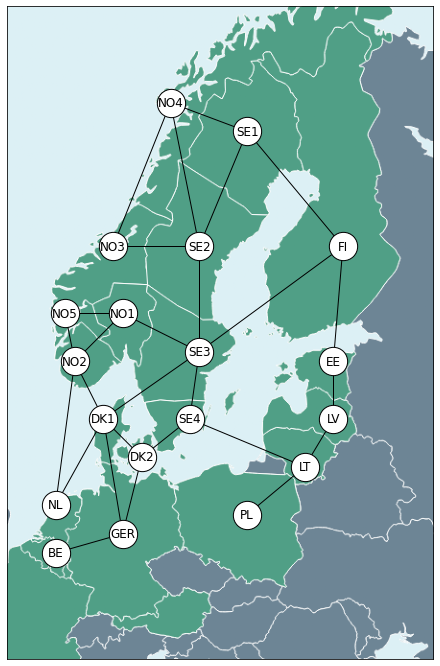

In [7]:
from europeExample import *
plotMap(capacitiesEur)

Alla överföringskapaciteter är hämtade från Nordpool och gäller för timmen 17:00-18:00, 2024-09-18. Exakta budkurvor publiceras tyvärr inte av Nordpool (bud är konfidentiella) så istället konstruerar vi syntetiska budkurvor baserade på ungefär hur mycket som köptes/såldes i varje zon just den timmen. Det resulterande systemet med 19 zoner löser vi som innan. Notera situationen i SE4

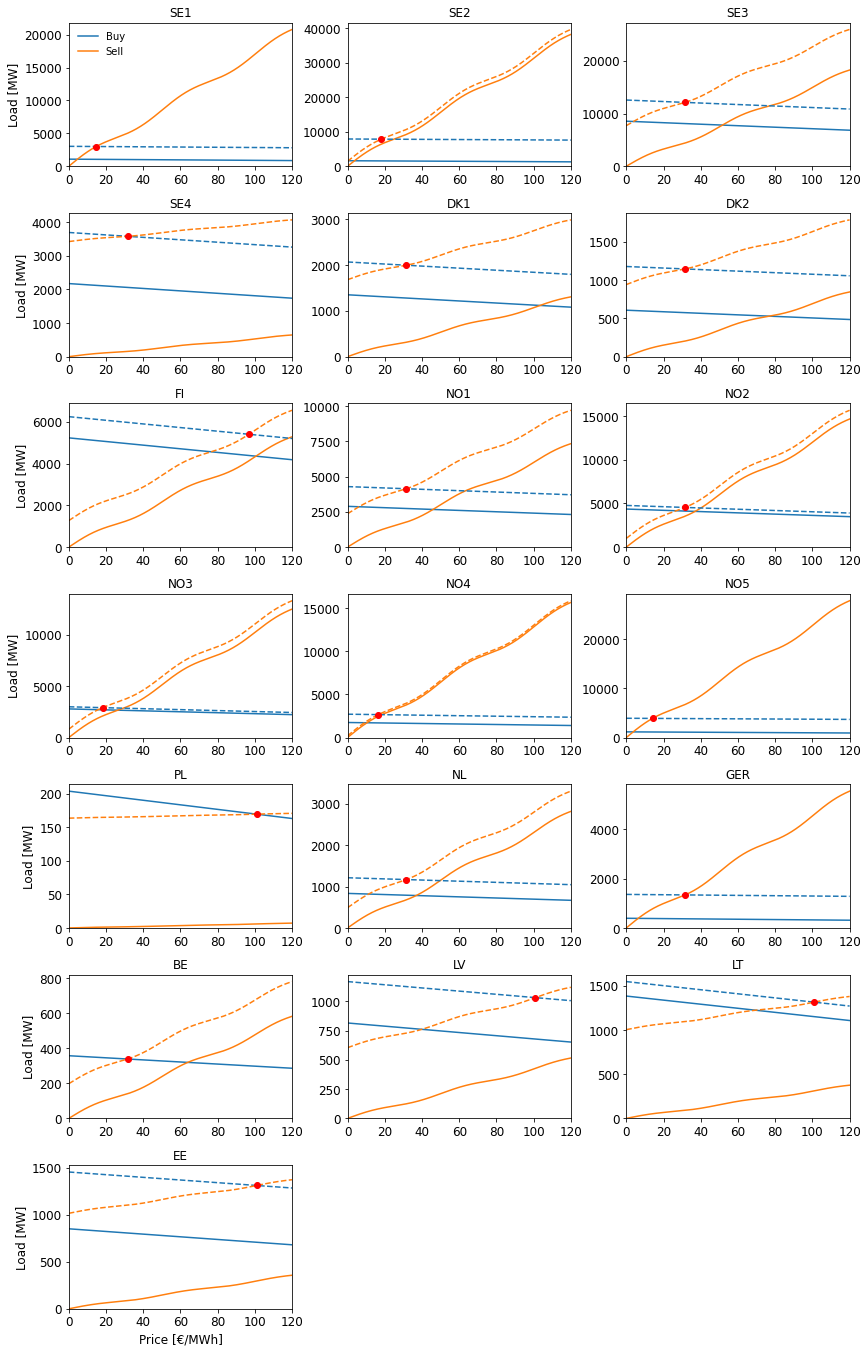

In [8]:
p_ref1 = 30
consumers = [lambda p, i=j : np.maximum(0, buy[i] - 0.05*buy[i]*p/p_ref1) for j in range(19)]
producers = [lambda p, i=j : sell[i] * 1/p_ref[i] * (p + 3.0*np.sin(p/8)) for j in range(19)]

x,f2z = solvePriceBalance(producers, consumers, capacitiesEur, printInfo=0)
plotBids2D(producers,consumers,x,f2z,xMin=0,xMax=120,ncols=3,labels=zoneNames)

Flödeskarta:

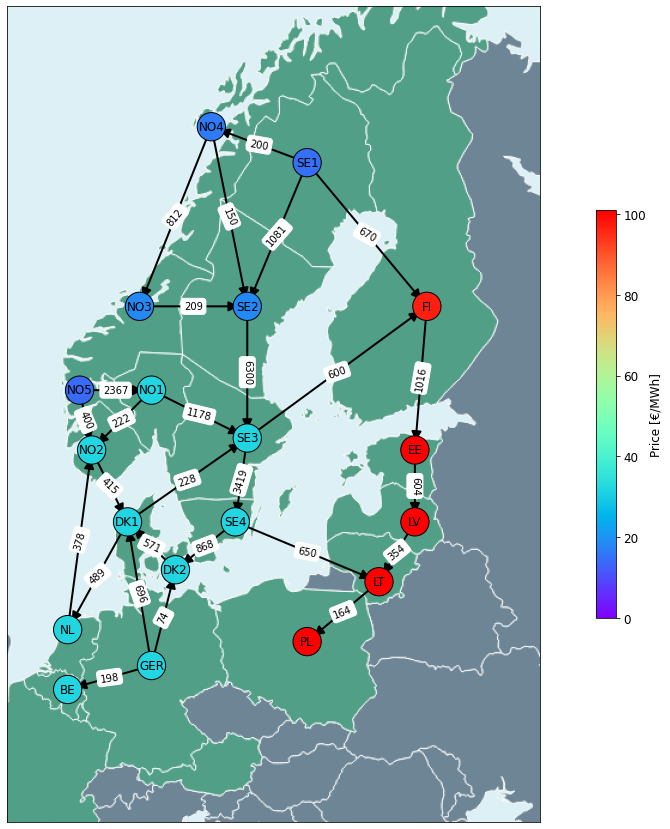

In [9]:
plotFlowMap(x, f2z)

Experimentera lite... 

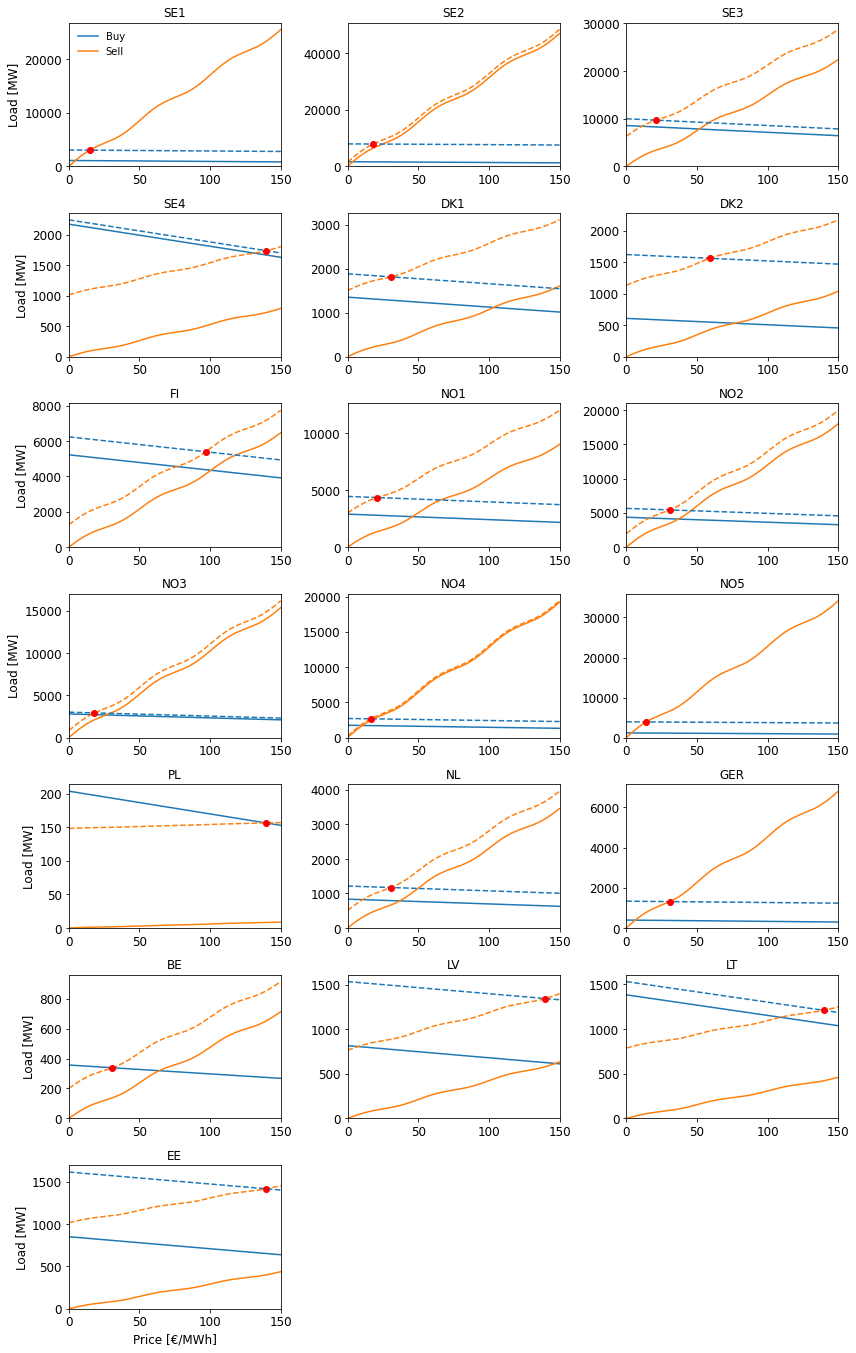

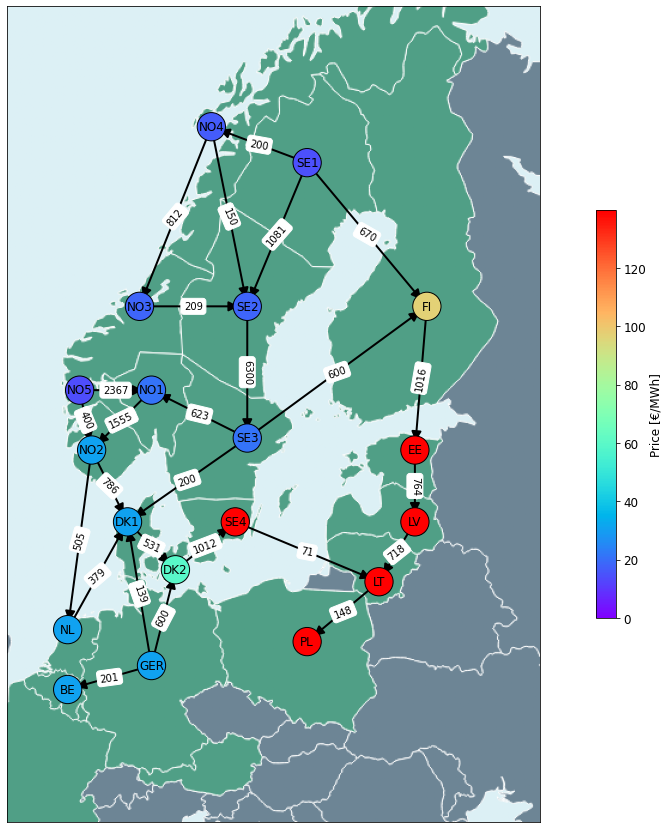

In [10]:
capacitiesNew = capacitiesEur
capacitiesNew[zi['SE3'],zi['SE4']] = 0
x,f2z = solvePriceBalance(producers, consumers, capacitiesNew, printInfo=0)
plotBids2D(producers,consumers,x,f2z,xMin=0,xMax=150,ncols=3,labels=zoneNames)
plotFlowMap(x,f2z)

I verkligheten kan det även finnas kapacitetsbegränsningar inom en zon. Zongränserna har lagts ungefär där det finns viktiga flaskhalsar i nätet men exakt var dessa flaskhalsar finns ändras såklart med tiden när nätet utvecklas och produktion/förbrukning ändras. Zongränserna kan också påverkas av politiska beslut.

När interna flaskhalsar uppstår inom en zon